Take Home Assignment 3

3.0 Install any dependencies if needed 


In [1]:
!pip install supervision
!pip install ultralytics


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Menuka\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [11]:
img_path = "demo5_images/cars1.jpg"
img = cv2.imread(img_path)


0: 416x640 14 cars, 378.6ms
Speed: 2.6ms preprocess, 378.6ms inference, 23.9ms postprocess per image at shape (1, 3, 416, 640)


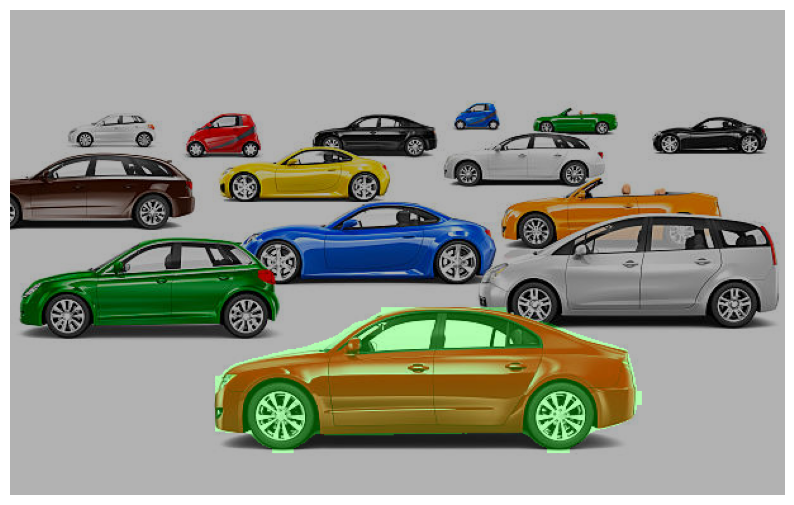

In [ ]:
# Load the YOLOv8 segmentation model
model = YOLO("yolov8s-seg.pt")  # You can use 'yolov8m-seg.pt' or 'yolov8l-seg.pt' for better accuracy


# Ensure image is loaded correctly
if img is None:
    raise ValueError(f"Error: Could not load image at {img_path}")

# Convert BGR to RGB for displaying 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Run the model on the image
results = model(img)

# Initialize variables to store the largest car mask
largest_area = 0
largest_mask = None

# Iterate through the detected objects
for result in results:
    for box, mask in zip(result.boxes.xyxy, result.masks.xy):
        x1, y1, x2, y2 = box  # Get bounding box coordinates
        area = (x2 - x1) * (y2 - y1)  # Compute area
        
        if area > largest_area:
            largest_area = area
            largest_mask = mask

# Draw the largest segmentation mask if found
if largest_mask is not None:
    mask_img = np.zeros_like(img_rgb, dtype=np.uint8)  # Create an empty mask image
    cv2.fillPoly(mask_img, [np.array(largest_mask, np.int32)], (0, 255, 0))  # Fill the mask with green color
    
    # Overlay mask on the original image
    output = cv2.addWeighted(img_rgb, 0.7, mask_img, 0.3, 0)
    
    # Display the output image in Colab
    plt.figure(figsize=(10, 10))
    plt.imshow(output)
    plt.axis("off")
    plt.show()

3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 306.4ms
Speed: 2.5ms preprocess, 306.4ms inference, 18.7ms postprocess per image at shape (1, 3, 416, 640)


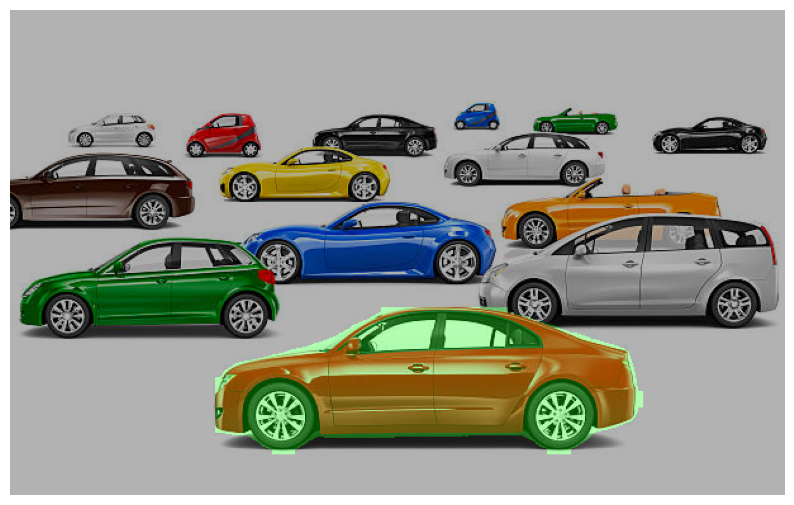

In [ ]:

# Load the YOLOv8 segmentation model
model = YOLO("yolov8s-seg.pt")  

# Read the image
img_path = "demo5_images/cars1.jpg"
img = cv2.imread(img_path)

# Ensure image is loaded correctly
if img is None:
    raise ValueError(f"Error: Could not load image at {img_path}")

# Convert BGR to RGB for displaying
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Run the model on the image
results = model(img)

# Transfer results to supervision
detections = sv.Detections.from_ultralytics(results[0])

# Initialize variables to store the largest car mask
largest_area = 0
largest_mask = None

# Iterate through the detected objects
for mask in detections.mask:
    if mask is not None:
        x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))  # Get bounding box
        area = w * h  # Compute area
        
        if area > largest_area:
            largest_area = area
            largest_mask = mask

# Display the largest segmentation mask if found
if largest_mask is not None:
    mask_img = np.zeros_like(img_rgb, dtype=np.uint8)  # Create an empty mask image
    mask_img[largest_mask.astype(bool)] = (0, 255, 0)  # Fill the mask with green color
    
    # Overlay mask on the original image
    output = cv2.addWeighted(img_rgb, 0.7, mask_img, 0.3, 0)
    
    # Display the output image
    plt.figure(figsize=(10, 10))
    plt.imshow(output)
    plt.axis("off")
    plt.show()

3.2 Estimate distance to centroid of chair 

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


Device set to use cpu



0: 384x640 1 chair, 103.7ms
Speed: 3.1ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Estimated depth at centroid (352, 181): 1.40 meters


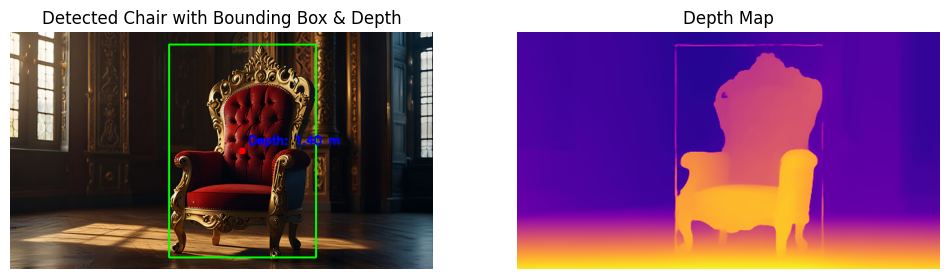

In [ ]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO 
from transformers import pipeline 
from PIL import Image
import matplotlib.pyplot as plt

# Load the object detection model
model = YOLO("yolov8n.pt")  

# Load the depth estimation model using Hugging Face pipeline
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")

def detect_chair(image_path):
    image = cv2.imread(image_path)
    results = model(image)[0]

    for detection in results.boxes:
        class_id = int(detection.cls)
        if results.names[class_id] == "chair":
            x1, y1, x2, y2 = map(int, detection.xyxy[0])
            centroid_x = (x1 + x2) // 2
            centroid_y = (y1 + y2) // 2

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box

            # Draw centroid
            cv2.circle(image, (centroid_x, centroid_y), 5, (0, 0, 255), -1)  # Red dot

            return image, (centroid_x, centroid_y), (x1, y1, x2, y2)

    return image, None, None

def get_depth_at_centroid(image, centroid):
    if centroid is None:
        print("No chair detected!")
        return None, None

    # Convert the image to RGB format 
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert OpenCV image to PIL Image
    pil_image = Image.fromarray(image_rgb)

    # Get the depth map using Hugging Face pipeline
    depth_map_pil = pipe(pil_image)["depth"]

    # Convert PIL Image to numpy array for easy indexing
    depth_map = np.array(depth_map_pil)

    # Extract depth value at the centroid position
    depth_value = depth_map[centroid[1], centroid[0]]  # Access depth at centroid
    depth_value_meters = depth_value / 100.0  # Assuming depth values are in cm, convert to meters
    return depth_map, depth_value_meters

# Main Execution
image_path = "demo5_images/kingChair.jpg"
image, centroid, bbox = detect_chair(image_path)

if centroid:
    depth_map, depth_value = get_depth_at_centroid(image, centroid)
    print(f"Estimated depth at centroid {centroid}: {depth_value:.2f} meters")

    # Draw depth value on the image
    cv2.putText(image, f"Depth: {depth_value:.2f} m", (centroid[0] + 10, centroid[1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Plot the image and depth map
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image with bounding box and centroid
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Detected Chair with Bounding Box & Depth')
    ax1.axis('off')

    # Plot the depth map
    ax2.imshow(depth_map, cmap='plasma') 
    ax2.set_title('Depth Map')
    ax2.axis('off')

    # Display the plots
    plt.show()
else:
    print("Chair not detected in the image.")


3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [14]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: d:\DOWNLOADs~\ETM4272-main\ETM4272-main\vehicles_video.mp4
100%|██████████| 35.3M/35.3M [02:22<00:00, 249kB/s]


'vehicles_video.mp4'

In [26]:
# Install necessary packages
!pip install gdown ultralytics supervision opencv-python numpy


In [ ]:
import gdown
import numpy as np
import supervision as sv
import cv2
from ultralytics import YOLO


#Load the YOLO model
model = YOLO("yolo11n.pt")  

#Define the callback function for processing each frame
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)  # Run YOLO on the frame

    # Convert results to Supervision format
    detections = sv.Detections.from_ultralytics(results[0])

    # Define a bounding box annotator
    box_annotator = sv.BoxAnnotator(thickness=8)

    # Filter detections for "cars" 
    car_class_id = 2  # Assuming "car" is class ID 2 
    car_detections = detections[detections.class_id == car_class_id]

    # Draw bounding boxes on the frame
    frame_with_boxes = box_annotator.annotate(scene=frame, detections=car_detections)

    return frame_with_boxes

#Process the video and save the output
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)

print("Processing complete! The result is saved as 'result_tracking.mp4'.")



0: 384x640 3 cars, 1 truck, 119.0ms
Speed: 2.0ms preprocess, 119.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 106.2ms
Speed: 3.6ms preprocess, 106.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 106.4ms
Speed: 3.1ms preprocess, 106.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 99.2ms
Speed: 3.3ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 128.5ms
Speed: 2.6ms preprocess, 128.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 142.5ms
Speed: 3.0ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 157.0ms
Speed: 4.5ms preprocess, 157.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 151.2ms
Speed: 4.0ms preproc

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [ ]:
import gdown
import numpy as np
import supervision as sv
import cv2
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("yolo11n.pt") 

# Initialize the tracker
tracker = sv.ByteTrack()  # ByteTrack for multi-object tracking

# Define the callback function for processing each frame
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)  # Run YOLO on the frame

    # Convert results to Supervision format
    detections = sv.Detections.from_ultralytics(results[0])

    # Define a bounding box annotator (Green boxes)
    box_annotator = sv.BoxAnnotator(thickness=8, color=sv.Color.GREEN)

    # Define a label annotator for Tracker IDs (White text)
    label_annotator = sv.LabelAnnotator(text_scale=1.0, text_thickness=2, text_color=sv.Color.WHITE)

    # Filter detections for "cars" 
    car_class_id = 2  # Assuming "car" is class ID 2
    car_detections = detections[detections.class_id == car_class_id]

    # Track the objects (assigns unique IDs)
    tracked_detections = tracker.update_with_detections(car_detections)

    # Draw bounding boxes
    frame_with_boxes = box_annotator.annotate(scene=frame, detections=tracked_detections)

    # Add tracker IDs as labels
    labels = [f"ID {tid}" for tid in tracked_detections.tracker_id]
    frame_with_labels = label_annotator.annotate(scene=frame_with_boxes, detections=tracked_detections, labels=labels)

    return frame_with_labels

# Process the video and save the output
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_ID.mp4",
    callback=callback
)

print("Processing complete! The result is saved as 'result_tracking_ID.mp4'.")



0: 384x640 3 cars, 1 truck, 199.1ms
Speed: 5.0ms preprocess, 199.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 123.6ms
Speed: 3.6ms preprocess, 123.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 103.1ms
Speed: 4.0ms preprocess, 103.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 102.3ms
Speed: 4.3ms preprocess, 102.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 110.5ms
Speed: 3.8ms preprocess, 110.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 136.0ms
Speed: 3.6ms preprocess, 136.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 104.3ms
Speed: 3.0ms preprocess, 104.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 130.4ms
Speed: 2.5ms prepr

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [ ]:
import gdown
import numpy as np
import supervision as sv
import cv2
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("yolo11n.pt")  

# Initialize the tracker
tracker = sv.ByteTrack()  # ByteTrack for multi-object tracking

# Initialize TraceAnnotator for drawing track traces
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=20, color=sv.Color.RED)

# Define the callback function for processing each frame
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)  # Run YOLO on the frame

    # Convert results to Supervision format
    detections = sv.Detections.from_ultralytics(results[0])

    # Define a bounding box annotator (Green boxes)
    box_annotator = sv.BoxAnnotator(thickness=8, color=sv.Color.GREEN)

    # Define a label annotator for Tracker IDs (White text)
    label_annotator = sv.LabelAnnotator(text_scale=1.0, text_thickness=2, text_color=sv.Color.WHITE)

    # Filter detections for "cars" (Class ID may need adjustment)
    car_class_id = 2  # Assuming "car" is class ID 2 
    car_detections = detections[detections.class_id == car_class_id]

    # Track the objects (assigns unique IDs)
    tracked_detections = tracker.update_with_detections(car_detections)

    # Draw bounding boxes
    frame_with_boxes = box_annotator.annotate(scene=frame, detections=tracked_detections)

    # Add tracker IDs as labels
    labels = [f"ID {tid}" for tid in tracked_detections.tracker_id]
    frame_with_labels = label_annotator.annotate(scene=frame_with_boxes, detections=tracked_detections, labels=labels)

    # Draw track traces
    frame_with_traces = trace_annotator.annotate(scene=frame_with_labels, detections=tracked_detections)

    return frame_with_traces

# Process the video and save the output
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_traces.mp4",
    callback=callback
)

print("Processing complete! The result is saved as 'result_tracking_traces.mp4'.")



0: 384x640 3 cars, 1 truck, 117.8ms
Speed: 3.7ms preprocess, 117.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 108.8ms
Speed: 4.0ms preprocess, 108.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 116.9ms
Speed: 3.0ms preprocess, 116.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 107.7ms
Speed: 3.0ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 172.1ms
Speed: 4.0ms preprocess, 172.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 125.1ms
Speed: 3.0ms preprocess, 125.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 103.5ms
Speed: 3.0ms preprocess, 103.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 118.3ms
Speed: 5.3ms prepr

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

_ANSWER_

This Python function declaration that specifies how each frame of a video is processed in real-time

(1.) Function Name: callback

    •Function is designed to be used as a callback function for processing video frames and also It is called automatically for each frame while processing the video.

(2.) Parameters:

    frame: np.ndarray

    • frame: This is a NumPy array representing the current video frame.
    • A frame is just an image (a 3D array of pixel values with shape (height, width, channels)).
           
    _: int
    • Underscore (_) is a throwaway variable in Python. It represents a second argument that isn't used in the function. In this case, it's the frame index (frame number), but since in above task it is not needed it, it's ignored.

(3.) Return Type:

     -> np.ndarray

    • This is a type hint that tells us the function returns a NumPy array. This array is the processed frame after adding bounding boxes, tracker IDs, and traces

Purpose of callback

    • The function takes an input frame, processes it (by detecting, tracking, and annotating objects), and then returns the modified frame. This function is repeatedly called for each frame in the video.

Example Execution Flow
1.	Receives a frame from the video.
2.	Runs YOLO to detect objects.
3.	Filters detections to track only cars.
4.	Assigns unique tracker IDs to cars.
5.	Draws bounding boxes, labels, and track traces.
6.	Returns the updated frame, which is then written to the output video.















